In [1]:
from monai.transforms import (
    EnsureChannelFirstd,
    LoadImage,
    LoadImaged,
    Orientationd,
    Rand3DElasticd,
    RandAffined,
    Spacingd,
)
from monai.config import print_config

import numpy as np
import shutil
import glob
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
print_config()

MONAI version: 1.2.dev2302
Numpy version: 1.19.5
Pytorch version: 1.13.1+cu116
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 708e1a1cf4a1d5516eaf65b8a0bee8887cdee494
MONAI __file__: c:\users\user\appdata\local\programs\python\python38\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 4.0.1
scikit-image version: 0.19.3
Pillow version: 9.1.1
Tensorboard version: 2.9.1
gdown version: 4.6.0
TorchVision version: 0.14.1+cu116
tqdm version: 4.64.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.1
pandas version: 1.4.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-depen

In [3]:
os.listdir("data/")

['images', 'manual_spleen_segmentations']

In [4]:
train_images= sorted(glob.glob("data/images/*.nii"))
train_labels= sorted(glob.glob("data/manual_spleen_segmentations/*.nii"))

In [5]:
data_dict= [{"image": image_name, "label": label_name}
            for image_name, label_name in zip(train_images, train_labels)]

In [6]:
data_dict[0]

{'image': 'data/images\\00001---002.nii',
 'label': 'data/manual_spleen_segmentations\\00001---002.nii'}

## load one nii image and its metadata

In [7]:
img_loader = LoadImage(dtype=np.float32)

In [8]:
img, meta= img_loader(data_dict[0]["image"])

In [9]:
meta

{'sizeof_hdr': array(348),
 'extents': array(0),
 'session_error': array(0, dtype=int16),
 'dim_info': array(0, dtype=uint8),
 'dim': array([  3, 512, 512, 116,   1,   1,   1,   1], dtype=int16),
 'intent_p1': array(0., dtype=float32),
 'intent_p2': array(0., dtype=float32),
 'intent_p3': array(0., dtype=float32),
 'intent_code': array(0, dtype=int16),
 'datatype': array(64, dtype=int16),
 'bitpix': array(64, dtype=int16),
 'slice_start': array(0, dtype=int16),
 'pixdim': array([1.   , 0.644, 0.644, 4.   , 1.   , 1.   , 1.   , 1.   ],
       dtype=float32),
 'vox_offset': array(0., dtype=float32),
 'scl_slope': array(nan, dtype=float32),
 'scl_inter': array(nan, dtype=float32),
 'slice_end': array(0, dtype=int16),
 'slice_code': array(0, dtype=uint8),
 'xyzt_units': array(0, dtype=uint8),
 'cal_max': array(0., dtype=float32),
 'cal_min': array(0., dtype=float32),
 'slice_duration': array(0., dtype=float32),
 'toffset': array(0., dtype=float32),
 'glmax': array(0),
 'glmin': array(0),
 

In [10]:
print(f"image slpe:\n{meta['scl_slope']}")

image slpe:
nan


## load & plot one nii image

In [11]:
one_img_loader= LoadImage(image_only= True, dtype= np.float32)

In [12]:
image= one_img_loader(data_dict[0]["image"])
print(f"input: {data_dict[0]['image']}") # volume path and name
print(f"shape: {image.shape}")
print(f"pixdim: {image.pixdim}")
print(f"affine: \n {image.meta['affine']}")

input: data/images\00001---002.nii
shape: torch.Size([512, 512, 116])
pixdim: tensor([0.6440, 0.6440, 4.0000], dtype=torch.float64)
affine: 
 tensor([[0.6440, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6440, 0.0000, 0.0000],
        [0.0000, 0.0000, 4.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000]], dtype=torch.float64)


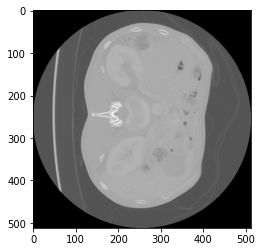

In [13]:
plt.figure(figsize=(8, 4))
plt.imshow(image[:, :, 80], cmap= 'gray')

## load & plot image and mask

In [14]:
image_mask_loader= LoadImaged(keys= ("image", "label"), image_only= False)

In [15]:
sample_dict= image_mask_loader(data_dict[0]) # it's a dict datatype

In [16]:
type(sample_dict)

dict

In [17]:
print(f"image shape: {sample_dict['image'].shape}") ### Note: inside f"" should be sigle quote
print(f"label shape: {sample_dict['label'].shape}")
print(f"image pixdim: {sample_dict['image'].pixdim}")

image shape: torch.Size([512, 512, 116])
label shape: torch.Size([512, 512, 116])
image pixdim: tensor([0.6440, 0.6440, 4.0000], dtype=torch.float64)


In [18]:
# load voxel data from dict into the variables:
image, label = sample_dict['image'], sample_dict['label']

Text(0.5, 1.0, 'mask')

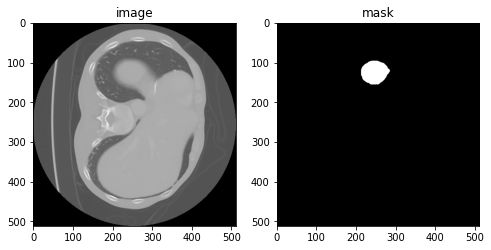

In [19]:
plt.figure(figsize= (8, 6))
plt.subplot(121)
plt.imshow(image[:, :, 100], cmap= 'gray')
plt.title("image")

plt.subplot(122)
plt.imshow(label[:, :, 100], cmap= 'gray')
plt.title("mask")

## Ensure the first dimension is channel

In [ ]:
# [num_channels, spatial_dim1, spatial_dim2, spatial_dim3]

In [ ]:
ensure_channel_first_transform= EnsureChannelFirstd(keys= ["image", "label"])
sample_dict_channelfirst= ensure_channel_first_transform(sample_dict)

print(f"image shape: {sample_dict_channelfirst['image'].shape}")

## Reorientation to a designated axes codes

transform all the input volumes in a consistent axes orientation.  
The default axis labels are Left (L), Right (R), Posterior (P), Anterior (A), Inferior (I), Superior (S).  
The following transform is created to reorientate the volumes to have 'Posterior, Left, Inferior' (PLI) orientation (To ensure the spatial axes are processed consistently across the subjects, this orientation transform should be put before any anisotropic spatial transforms):

In [ ]:
orientation_transform= Orientationd(keys=["image", "label"], axcodes= "PLI")

In [ ]:
sample_dict_oriented= orientation_transform(sample_dict_channelfirst)

In [ ]:
print(f"image shape after reorientation: {sample_dict_oriented['image'].shape}")
print(f"image shape before reorientation {sample_dict_channelfirst['image'].shape}")
print(f"")

## resample to the consistent voxel size

In [ ]:
spacing_transform= Spacingd(keys= ["image", "label"], pixdim= (1.5, 1.5, 5.0), mode= ("bilinear", "nearest"))

In [ ]:
sample_resampled= spacing_transform(sample_dict_oriented)

In [ ]:
print(f"image shape before resampling: {sample_dict_oriented['image'].shape}")
print(f"image shape after resampling: {sample_resampled['image'].shape}")
print(f"image affine before resampling: {sample_dict_oriented['image'].meta['affine']}")
print(f"image affine after resampling: \n {sample_resampled['image'].meta['affine']}")
print("===="*20)

print(f"image pixdim before resampling: {sample_dict_oriented['image'].pixdim}")
print(f"image pixdim after resampling: {sample_resampled['image'].pixdim}")

In [ ]:
image, label= sample_resampled['image'], sample_resampled['label']

plt.subplot(121)
plt.imshow(image[0, :, :, 18], cmap= 'gray')
plt.title("image")

plt.subplot(122)
plt.imshow(label[0, :, :, 18], cmap= 'gray')
plt.title("mask")